# Home Credit Default Risk

Risk is an unavoidable part of all human activities and occurs in everyday life. When dealing on financial markets investors are facing to financial risk, which is defined as potential financial loss. Banks encounter many types of risks. As most significant risk is credit risk due to the high exposure of banks in credit transactions. 

An existential problem for any Loan providers is to detect the Loan applicants who are very unlikely to repay the loan. Credit institutions aim to develope credit risk model capable of distinquishing between good and bad loans. Ability to recognise default-prone credit contracts help companies avoid losses and incur huge profits.

##### Paper:        
Master thesis
##### Author:       
Marko Vateha
##### Institution:  
University of Economics and Business in Bratislava

![UEBR](https://euba.sk/www_write/images/cache/3dc4b38399662dd1a15ad970fd72c08e_w1200.jpg)

# Part II. Feature Selection

Feature Selection is the process of selecting a subset of relevant features (variables, predictors) for use in model construction. Feature selection techniques are used for several reasons:

* simplification of models to make them easier to interpret by researchers/users,[1]
* shorter training times,
* to avoid the curse of dimensionality,
* enhanced generalization by reducing overfitting[2] (formally, reduction of variance[1])

### 01. First steps

Here we import module we will work with and read the data we have already preprocessed.

#### 1.1 Importing modules:

In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats

#### 1.2 Reading preprocessed data

In [2]:
atrain = pd.read_csv(r'export\export_04_11_2019.csv', index_col='SK_ID_CURR')
atrain.head()

,TARGET,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FONDKAPREMONT_MODE,HOUSETYPE_MODE,EMERGENCYSTATE_MODE,...,Y_TOTALAREA_MODE,Y_EMERGENCYSTATE_MODE,Y_OCCUPATION_TYPE,Y_EXT_SOURCE_3,Y_AMT_REQ_CREDIT_BUREAU_YEAR,Y_AMT_REQ_CREDIT_BUREAU_QRT,Y_AMT_REQ_CREDIT_BUREAU_HOUR,Y_AMT_REQ_CREDIT_BUREAU_DAY,Y_AMT_REQ_CREDIT_BUREAU_WEEK,Y_AMT_REQ_CREDIT_BUREAU_MON
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,1,1,1,1,1,1,1,1,1
100003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,1,1,0,1,1,1,1,1,1
100004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,1,1,1,1,1,1,1
100006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
100007,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0,0,1,0,1,1,1,1,1,1


#### 1.3 Splitting to Continuous and Categorical variables

The significance test varies for continuous and discrete variable, hence, we need to split them.

In [3]:
likely_cont = {}
for var in atrain.columns:
    likely_cont[var] = 1.*atrain[var].nunique()/atrain[var].count() > 0.0001
    
col_cont = []  
col_cat = []
for k,v in zip(list(likely_cont.keys()), list(likely_cont.values())):
    if v:
        col_cont.append(k)
    else:
        col_cat.append(k)

In [20]:
print(len(col_cont))
print(len(col_cat))

63
279


### 02. Statistical significance

#### 2.1 T-test for continuous data

A t-test is a type of inferential statistic used to determine if there is a significant difference between the means of two groups, which may be related in certain features. 

Observations for each column (attribute) we will split to two group. First group consists of observations where target variable is 1 (default), second group is formed by good loan (target = 0).

If there is significant difference between the groups, then the P value of T-test is less than 0.05.

In [58]:
signif_col_cont = []
non_signif_col_cont = []

for col in col_cont:
    default = atrain[atrain['TARGET']==1][col]
    non_default = atrain[atrain['TARGET']==0][col]
    
    stat, p = stats.ttest_ind(default, non_default, equal_var = False)
    if p < 0.05:
        signif_col_cont.append((col,p))
    if p > 0.05:
        non_signif_col_cont.append((col,p))

print(len(signif_col_cont))

57


##### Non-significant (eliminated)

In [23]:
non_signif_col_cont

['YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BEGINEXPLUATATION_MODE',
 'LANDAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'LANDAREA_MEDI',
 'INCOME_TO_CREDIT_RATIO']

#### 2.2 Chi-square Test of Independence

Pearson's chi-squared test is used to determine whether there is a statistically significant difference between the expected frequencies and the observed frequencies in one or more categories of a contingency table.

This means, if belonging to one group is statistically significant for distinguishing between good and bad loans.

In [35]:
signif_col_cat = []
non_signif_col_cat = []

for col in col_cat:
    ar1 = [len(atrain[col][(atrain['TARGET']==0) & (atrain[col]==1)]), len(atrain[col][(atrain['TARGET']==1) & (atrain[col]==1)])]
    ar2 = [len(atrain[col][(atrain['TARGET']==0) & (atrain[col]==0)]), len(atrain[col][(atrain['TARGET']==1) & (atrain[col]==0)])]
    obser = np.array([ar1,ar2])
    chi2, p, dof, ex = stats.chi2_contingency(obser)
    
    if p < 0.05:
        signif_col_cat.append((col,p))
    if p > 0.05:
        non_signif_col_cat.append((col,p))

print(len(signif_col_cat))

196


### 03. Significance of variables

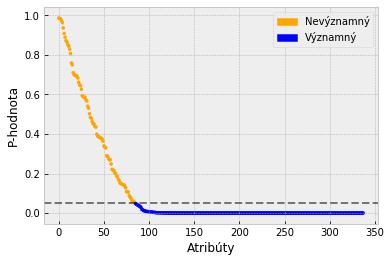

In [132]:
s = signif_col_cat + non_signif_col_cat + signif_col_cont + non_signif_col_cont
s = sorted(s, key = lambda x: x[1], reverse=True)

x= np.arange(len(s))
y= []
for i in s:
    y.append(i[1])
y= np.array(y)

color = []
for i in s:
    if i[1]>0.05:
        color.append('orange')
    else:
        color.append('blue')

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt    
    
plt.style.use('bmh')
plt.scatter(x,y, marker='.', c=color)
plt.xlabel('Atribúty')
plt.ylabel('P-hodnota')
orange_patch = mpatches.Patch(color='orange', label='Nevýznamný')
blue_patch = mpatches.Patch(color='blue', label='Významný')
plt.legend(handles=[orange_patch, blue_patch])
plt.axhline(y=0.05, ls='--', c='k', alpha=0.5)
plt.show()

##### Selecting only significant ones

In [135]:
signif_cols = signif_col_cat + signif_col_cont

signif= []
for col, p_val in signif_cols:
    signif.append(col)

atrain_sel = atrain[signif]

### 04. Multicollinearity

#### 4.1 Copy for processing

In [ ]:
X_train_1 = train_sel[signif].copy()
y_train_1 = train_sel.iloc[:,0].copy()
X_test_1 = test_sel[signif].copy()
y_test_1 = test_sel.iloc[:,0].copy()

#### 4.2 Correlation Kendall-tauB

In [25]:
corr = pd.merge(y_train_1, X_train_1, left_index=True, right_index=True).corr(method='kendall')

In [28]:
corr = abs(corr)

In [29]:
cols = list(corr.columns)
bad = []
good = []
for col in cols:
    s = list(corr.index[corr[col]>0.8])
    if len(s)>1:
        bad.append(s)
    else:
        good.append(s[0])

good.remove('TARGET')     
w=[]
delete = []

for element in bad:
    inventar = element.copy()
    threshold=0
    for j in element:
        value = abs(corr['TARGET'][j])
        if value>threshold:
            column = j
            threshold = value
    inventar.remove(column)
    for e in inventar:
        delete.append(e)
final = set(delete)
     

In [30]:
len(good) + len(bad)

254

In [31]:
len(bad) - len(final)

28

In [32]:
for col in final:
    X_test_1.drop([col],axis=1,inplace=True)
    X_train_1.drop([col],axis=1,inplace=True)
len(X_test_1.columns), len(X_train_1.columns)

(159, 159)

In [33]:
len(X_test.columns), len(X_train.columns)

(339, 339)

In [ ]:
X_train_1.to_csv('X_train_1.csv')
X_test_1.to_csv('X_test_1.csv')
y_train_1.to_csv('y_train_1.csv')
y_test_1.to_csv('y_test_1.csv')